In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver
from src import regmod_torch

from tqdm import tqdm
import importlib

## Compare with microstructure maps

Contents:
- Various effective delay (hyperparameter grid)


In [42]:
resources_path = "../resources"
data_path = '/Users/mikichan/Desktop/mywork/atlas_data/'

fibers_array = utils.load(op.join(resources_path,'fiber_lengths.pkl'))
N = fibers_array.shape[0]

region_file = op.join(data_path, 'f-tract_v2112', 'F-TRACT-090624/Lausanne2008-33.txt')
region_file2 = op.join(resources_path, 'hcp_3t_microstructure_lausanne2008', 'regions_scale1.txt')

In [47]:
ad_results_wide = utils.load(op.join(resources_path,'landscape_results.pkl'))
ad_results_coarse = utils.load(op.join(resources_path, 'landscape_results_coarser.pkl'))

alpha_space_wide = np.linspace(0, 10, 21)
delta_space_wide = np.linspace(0, 60, 21)

alpha_space_coarse = np.linspace(0, 2, 11)
delta_space_coarse = np.linspace(25, 40, 11)

ad_matrix_wide = {}
ad_matrix_coarse = {}

for (u,v) in ad_results_wide.items():
    opt = utils.add_diagonal_entries(v[0].reshape(fibers_array.shape[0], fibers_array.shape[1]-1))
    ad_matrix_wide[u] = opt

for (u,v) in ad_results_coarse.items():
    opt = utils.add_diagonal_entries(v[0].reshape(fibers_array.shape[0], fibers_array.shape[1]-1))
    ad_matrix_coarse[u] = opt

In [51]:
with open(region_file) as f:
    atlas_2008_regions = f.readlines()

with open(region_file2) as f:
    microstruct_regions = f.readlines()

In [52]:
atlas_2008_regions = [regionname.replace('.','-').lower().strip() for k, regionname in enumerate(atlas_2008_regions)]
for sidx, region in enumerate(atlas_2008_regions):
    if 'right' in region:
        atlas_2008_regions[sidx] = region.replace('right','rh')
    if 'left' in region:
        atlas_2008_regions[sidx] = region.replace('left','lh')

match_indexes = np.zeros(len(atlas_2008_regions)) - 1
for k in range(len(atlas_2008_regions)):
    for sidx, searchname in enumerate(microstruct_regions):
        if atlas_2008_regions[k] in searchname:
            match_indexes[k] = sidx
        if 'lh-accumbens-area' in atlas_2008_regions[k]:
            if 'lh-accumbens' in searchname:
                match_indexes[k] = sidx
        if 'rh-accumbens-area' in atlas_2008_regions[k]:
            if 'rh-accumbens' in searchname:
                match_indexes[k] = sidx
                
rightth = np.where(['thal' in tmp for tmp in microstruct_regions])[0][:7]
leftth = np.where(['thal' in tmp for tmp in microstruct_regions])[0][7:]

In [78]:
# MANUAL-MATCHING: of regions for microstrucure array creation
microstructs_labels = ['Da', 'De_par', 'De_perp', 'f', 'p2']

microstruct_matrix = {}
for label in microstructs_labels:
    microstruct_conn = np.load(op.join(resources_path, 'hcp_3t_microstructure_lausanne2008', f'{label}.npy'))
    microstruct_conn -= np.diag(np.diag(microstruct_conn))

    microstruct_array = np.zeros((N+1, N+1))
    for ridx in range(len(fibers_array)):
        for cidx in range(len(fibers_array)):
            
            if (ridx == 83) or (cidx == 83):
                microstruct_array[ridx, cidx] = np.nan
            else:
                if ridx == 34 and cidx == 34: microstruct_array[ridx, cidx] = microstruct_conn[rightth][:, rightth].mean()
                elif ridx == 34 and cidx == 75: microstruct_array[ridx, cidx] = microstruct_conn[rightth][:, leftth].mean()
                elif ridx == 75 and cidx == 34: microstruct_array[ridx, cidx] = microstruct_conn[leftth][:, rightth].mean()
                elif ridx == 75 and cidx == 75: microstruct_array[ridx, cidx] = microstruct_conn[leftth][:, leftth].mean()
                else:
                    microstruct_array[ridx, cidx] = microstruct_conn[int(match_indexes[ridx]), int(match_indexes[cidx])]

    microstruct_array = microstruct_array[:N, :N]
    microstruct_array = np.nan_to_num(microstruct_array)
    microstruct_matrix[label] = microstruct_array

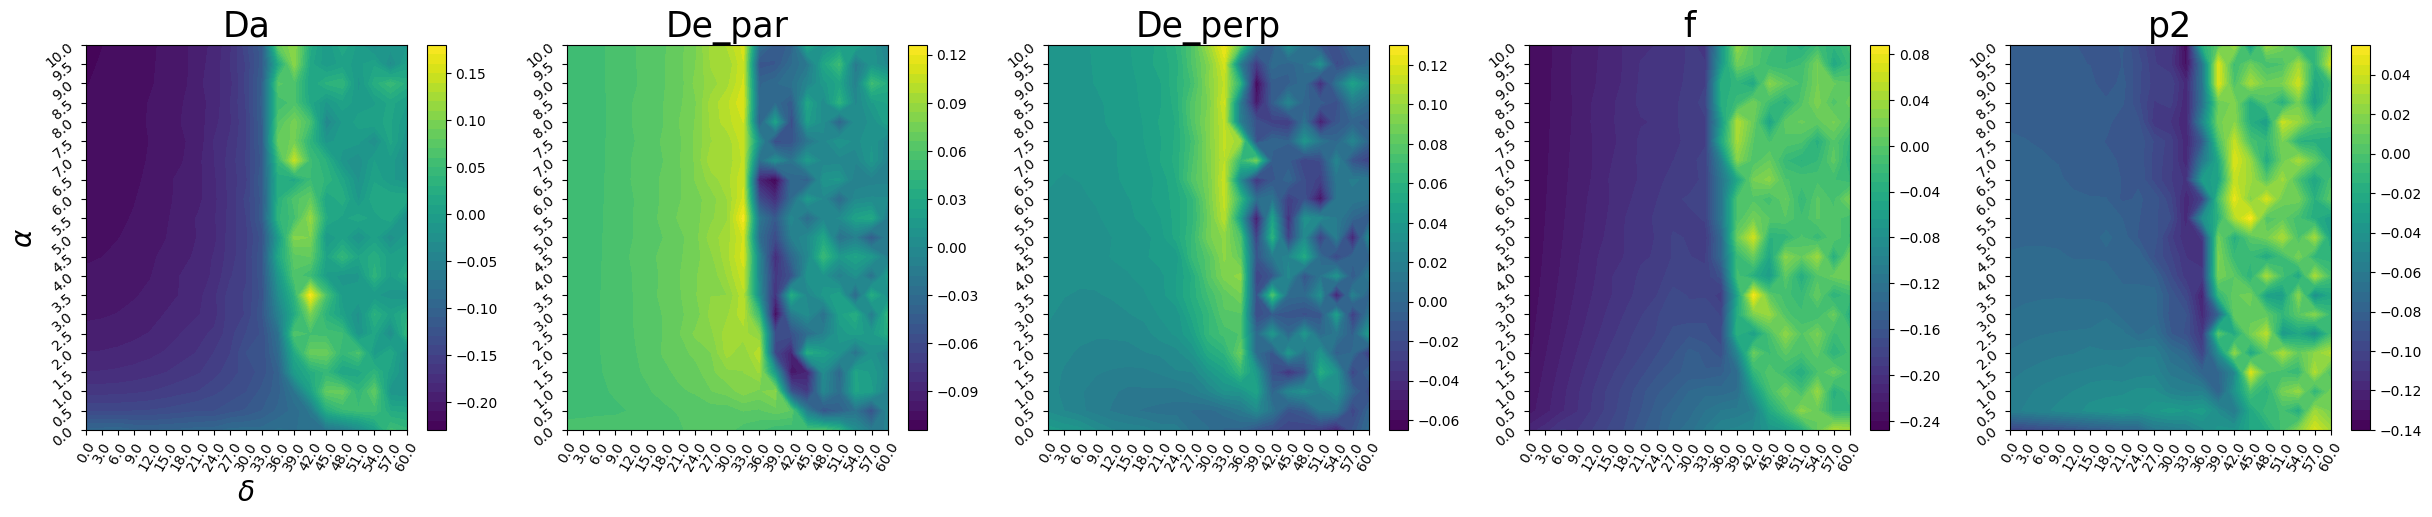

In [110]:
from scipy import stats

corr_labels = {}
for label in microstructs_labels:
    corr_land = np.zeros((len(alpha_space_wide), len(delta_space_wide)))
    for aidx, alpha in enumerate(alpha_space_wide):
        for didx, delta in enumerate(delta_space_wide):
            opt = ad_matrix_wide[(aidx,didx)]

            mask = np.logical_and((opt > 0.1), (microstruct_matrix[label] > 0))

            y = opt[mask]
            x = microstruct_matrix[label][mask]
            
            corr = stats.pearsonr(x, y)[0]
            corr_land[aidx, didx] = corr
    corr_labels[label] = corr_land

x, y = np.meshgrid(delta_space_wide, alpha_space_wide)

fig, ax = plt.subplots(1, 5, figsize=(30,5))

lands_label = microstructs_labels

for k, label in enumerate(lands_label):

    cs = ax[k].contourf(x/3, y*2, corr_labels[label], 40)
    ax[k].set_xticks(np.arange(len(delta_space_wide)), labels=delta_space_wide, rotation=60) # Realign the ticks
    ax[k].set_title(lands_label[k], size=25)
    plt.colorbar(cs, ax=ax[k])

    ax[k].set_yticks(np.arange(len(alpha_space_wide))[::-1], 
                     labels=np.round(alpha_space_wide.astype(float)[::-1],3), rotation=40)
    if k == 0:
        ax[k].set_xlabel(r'$\delta$', size=20)
        ax[k].set_ylabel(r'$\alpha$', size=20)

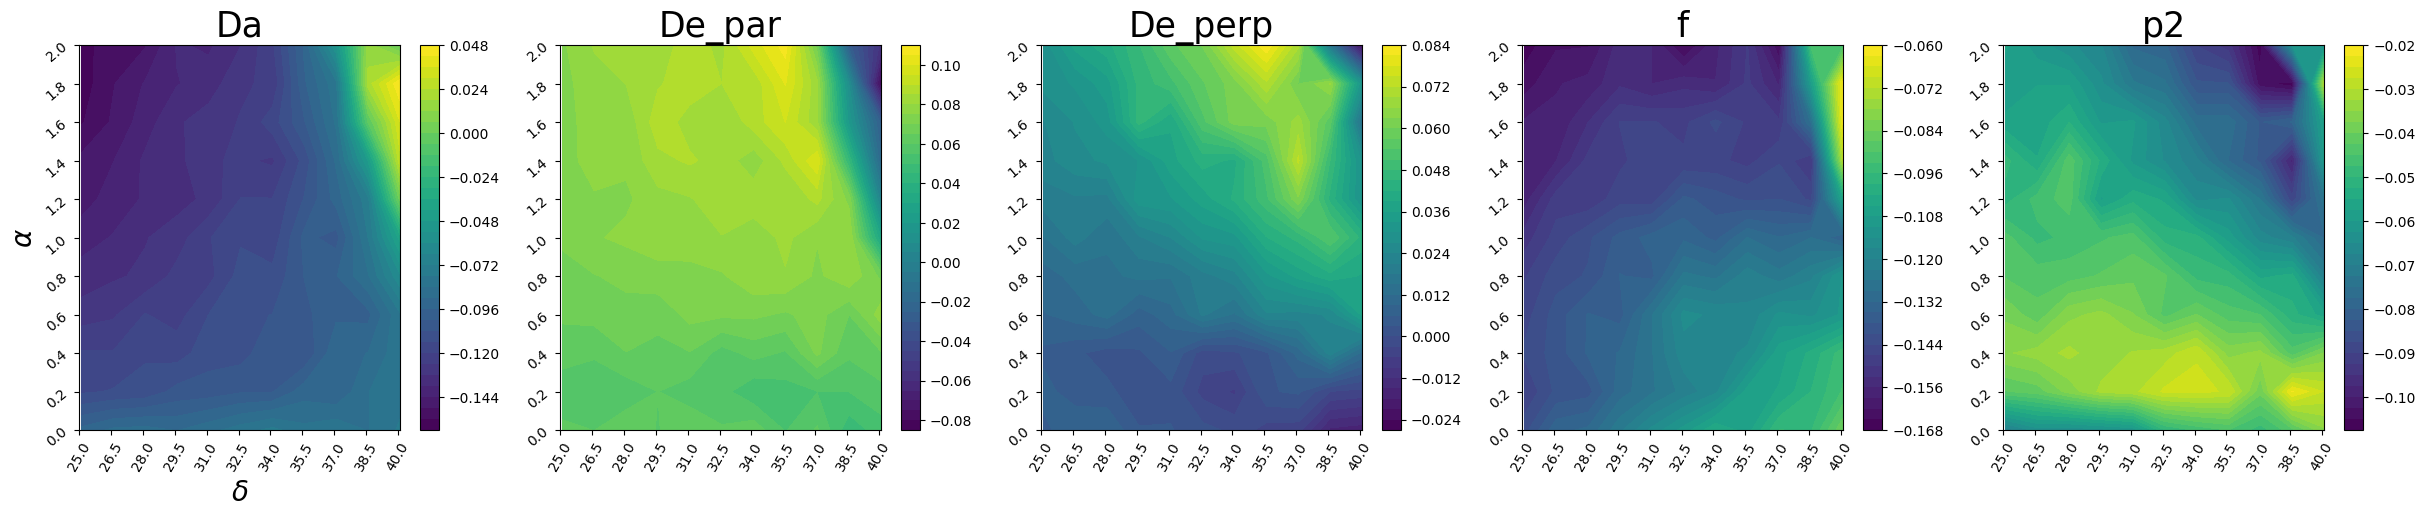

In [112]:
corr_labels = {}
for label in microstructs_labels:
    corr_land = np.zeros((len(alpha_space_coarse), len(delta_space_coarse)))
    for aidx, alpha in enumerate(alpha_space_coarse):
        for didx, delta in enumerate(delta_space_coarse):
            opt = ad_matrix_coarse[(aidx,didx)]

            mask = np.logical_and((opt > 0.1), (microstruct_matrix[label] > 0))

            y = opt[mask]
            x = microstruct_matrix[label][mask]
            
            corr = stats.pearsonr(x, y)[0]
            corr_land[aidx, didx] = corr
    corr_labels[label] = corr_land
    
x, y = np.meshgrid(delta_space_coarse, alpha_space_coarse)

fig, ax = plt.subplots(1, 5, figsize=(30,5))

lands_label = microstructs_labels

for k, label in enumerate(lands_label):

    # cs = ax[k].contourf(x/3, y * 2, corr_labels[label], 40, vmin=0, vmax=0.5)
    cs = ax[k].contourf(x/3, y * 2, corr_labels[label], 40)
    ax[k].set_xticks(np.arange(len(delta_space_coarse))/2+8.3, labels=delta_space_coarse, rotation=60) # Realign the ticks
    ax[k].set_title(lands_label[k], size=25)
    plt.colorbar(cs, ax=ax[k])

    ax[k].set_yticks(np.arange(len(alpha_space_coarse))[::-1]/2.5, 
                     labels=np.round(alpha_space_coarse.astype(float)[::-1],3), rotation=40)
    if k == 0:
        ax[k].set_xlabel(r'$\delta$', size=20)
        ax[k].set_ylabel(r'$\alpha$', size=20)

In [116]:
alpha_space_coarse, delta_space_coarse

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 array([25. , 26.5, 28. , 29.5, 31. , 32.5, 34. , 35.5, 37. , 38.5, 40. ]))

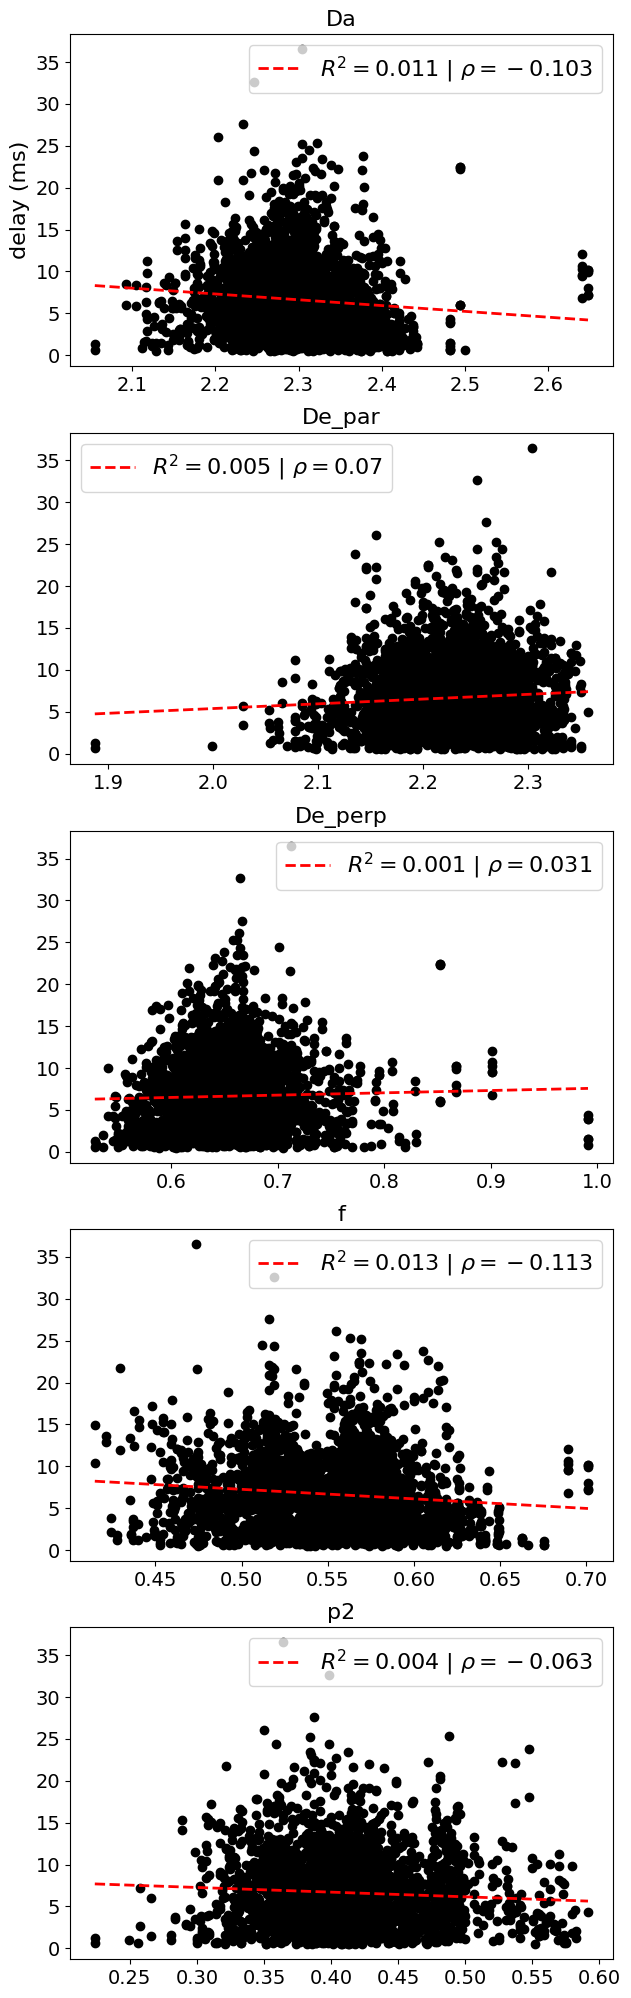

In [122]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(5, figsize=(7, 25))
for k, label in enumerate(microstructs_labels):

    opt = ad_matrix_coarse[(5, 4)]
    mask = np.logical_and((opt > 0.5), (microstruct_matrix[label] > 0))

    y = opt[mask]
    x = microstruct_matrix[label][mask]

    model = LinearRegression()
    model.fit(x.reshape(-1,1), y)

    r_squared = model.score(x.reshape(-1,1), y)
    
    corr = stats.pearsonr(x, y)[0]
    
    ax[k].scatter(x, y, color='k')
    ax[k].plot([x.min(), x.max()], [model.intercept_ + + x.min() * model.coef_[0], model.intercept_ + x.max() * model.coef_[0]], 
                  linewidth=2, color='r', linestyle='--', 
                  label=rf'$R^2={np.round(r_squared, 3)}$ | $\rho={np.round(corr,3)}$')
    
    ax[k].legend(fontsize=16)
    ax[k].set_title(f'{label}', fontsize=16)
    if (k == 0):
        # ax[k].set_xlabel('fiber length (mm)', fontsize=16)
        ax[k].set_ylabel('delay (ms)', fontsize=16)

    ax[k].tick_params(labelsize=14)